In [39]:
# Import all the necessary modules
import os
import sys
import os, sys
# from .../research/notebooks -> go up two levels to repo root
repo_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mtick
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 
import pandas_datareader as pdr
import math
import datetime
from datetime import datetime, timezone
import itertools
import ast
import yfinance as yf
import seaborn as sn
import yaml
from pathlib import Path
from IPython.display import display, HTML
from strategy_signal.trend_following_signal import (
    apply_jupyter_fullscreen_css, get_trend_donchian_signal_for_portfolio_with_rolling_r_sqr_vol_of_vol
)
from portfolio.strategy_performance import (calculate_sharpe_ratio, calculate_calmar_ratio, calculate_CAGR, calculate_risk_and_performance_metrics,
                                          calculate_compounded_cumulative_returns, estimate_fee_per_trade, rolling_sharpe_ratio)
from utils import coinbase_utils as cn
from portfolio import strategy_performance as perf
from sizing import position_sizing_binary_utils as size_bin
from sizing import position_sizing_continuous_utils as size_cont
from strategy_signal import trend_following_signal as tf
%matplotlib inline

In [41]:
import importlib
importlib.reload(cn)
importlib.reload(perf)
importlib.reload(tf)
importlib.reload(size_bin)
importlib.reload(size_cont)

<module 'sizing.position_sizing_continuous_utils' from '/Users/adheerchauhan/Documents/git/trend_following/sizing/position_sizing_continuous_utils.py'>

In [43]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('Display.max_rows', None)
pd.set_option('Display.max_columns',None)
apply_jupyter_fullscreen_css()

## Helper Functions

In [46]:
## Load Config file for the strategy
def load_prod_strategy_config(strategy_version='v0.1.0'):
    nb_cwd = Path.cwd()  # git/trend_following/research/notebooks
    config_path = (
            nb_cwd.parents[1]  # -> git/trend_following
            / "live_strategy"
            / f"trend_following_strategy_{strategy_version}-live"
            / "config"
            / f"trend_strategy_config_{strategy_version}.yaml"
    )

    print(config_path)  # sanity check
    print(config_path.exists())  # should be True

    with open(config_path, "r") as f:
        cfg = yaml.safe_load(f)

    return cfg

In [48]:
from collections import OrderedDict

def print_strategy_params():
    """
    Pretty-print the strategy’s configuration values, with a blank line
    separating each logical section.
    """

    # ---- Define sections (title is just for dev readability) --------------
    sections = [
        ("Dates & universe", OrderedDict([
            ("start_date",      start_date),
            ("end_date",        end_date),
            ("warm_up_days",    WARMUP_DAYS),
            ("ticker_list",     ticker_list),
        ])),

        ("Moving-average / trend", OrderedDict([
            ("fast_mavg",                  fast_mavg),
            ("slow_mavg",                  slow_mavg),
            ("mavg_stepsize",              mavg_stepsize),
            ("mavg_z_score_window",        mavg_z_score_window),
            ("moving_avg_type",            moving_avg_type),
            ("ma_crossover_signal_weight", ma_crossover_signal_weight),
        ])),

        ("Donchian channel", OrderedDict([
            ("entry_rolling_donchian_window", entry_rolling_donchian_window),
            ("exit_rolling_donchian_window", exit_rolling_donchian_window),
            ("use_donchian_exit_gate", use_donchian_exit_gate),
            ("donchian_signal_weight",  donchian_signal_weight),
        ])),

        ("Volatility & risk", OrderedDict([
            ("volatility_window",            volatility_window),
            ("annualized_target_volatility", annualized_target_volatility),
            ("rolling_cov_window",           rolling_cov_window),
            ("rolling_atr_window",           rolling_atr_window),
            ("atr_multiplier",               atr_multiplier),
            ("log_std_window",               log_std_window),
            ("coef_of_variation_window",     coef_of_variation_window),
            ("vol_of_vol_z_score_window",    vol_of_vol_z_score_window),
            ("vol_of_vol_p_min",             vol_of_vol_p_min),
            ("r2_strong_threshold",          r2_strong_threshold)
        ])),

        ("Signal gating / quality", OrderedDict([
            ("lower_r_sqr_limit",             lower_r_sqr_limit),
            ("upper_r_sqr_limit",             upper_r_sqr_limit),
            ("rolling_r2_window",             rolling_r2_window),
            ("r2_smooth_window",              r2_smooth_window),
            ("r2_confirm_days",               r2_confirm_days),
            ("rolling_sharpe_window",         rolling_sharpe_window),
            ("use_activation",                use_activation),
            ("tanh_activation_constant_dict", tanh_activation_constant_dict),
            ("weighted_signal_ewm_window",    weighted_signal_ewm_window)
        ])),

        ("Trading toggles & thresholds", OrderedDict([
            ("long_only",                  long_only),
            ("use_coinbase_data",          use_coinbase_data),
            ("use_saved_files",            use_saved_files),
            ("saved_file_end_date",        saved_file_end_date),
            ("use_specific_start_date",    use_specific_start_date),
            ("signal_start_date",          signal_start_date),
            ("price_or_returns_calc",      price_or_returns_calc),
            ("notional_threshold_pct",     notional_threshold_pct),
            ("cooldown_counter_threshold", cooldown_counter_threshold),
            ("warmup_days",                WARMUP_DAYS)
        ])),

        ("Capital & execution", OrderedDict([
            ("initial_capital",        initial_capital),
            ("cash_buffer_percentage", cash_buffer_percentage),
            ("transaction_cost_est",   transaction_cost_est),
            ("passive_trade_rate",     passive_trade_rate),
            ("annual_trading_days",    annual_trading_days),
        ])),
    ]

    # ---- Compute width for neat alignment ---------------------------------
    longest_key = max(len(k) for _, sec in sections for k in sec)

    print("\nStrategy Parameters\n" + "-" * (longest_key + 30))
    for _, sec in sections:
        for k, v in sec.items():
            print(f"{k:<{longest_key}} : {v}")
        print()  # blank line between sections
    print("-" * (longest_key + 30) + "\n")

# ---------------------------------------------------------------------------
# Example usage (uncomment after your own parameter definitions are in scope)
# ---------------------------------------------------------------------------
# if __name__ == "__main__":
#     print_strategy_params()

In [50]:
def plot_signal_performance(df_1, df_2, ticker):

    fig = plt.figure(figsize=(20,12))
    layout = (2,2)
    signal_ax = plt.subplot2grid(layout, (0,0))
    price_ax = signal_ax.twinx()
    equity_curve_ax = plt.subplot2grid(layout, (0,1))
    sharpe_ax = plt.subplot2grid(layout, (1,0))
    portfolio_value_ax = plt.subplot2grid(layout, (1,1))

    _ = signal_ax.plot(df_1.index, df_1[f'{ticker}_final_signal'], label='Orig Signal', alpha=0.9)
    _ = signal_ax.plot(df_2.index, df_2[f'{ticker}_final_signal'], label='New Signal', alpha=0.9)
    _ = price_ax.plot(df_1.index, df_2[f'{ticker}_open'], label='Price', alpha=0.7, linestyle='--', color='magenta')
    _ = signal_ax.set_title(f'Orignal Signal vs New Signal')
    _ = signal_ax.set_ylabel('Signal')
    _ = signal_ax.set_xlabel('Date')
    _ = signal_ax.legend(loc='upper left')
    _ = signal_ax.grid()

    _ = equity_curve_ax.plot(df_1.index, df_1[f'equity_curve'], label='Orig Signal', alpha=0.9)
    _ = equity_curve_ax.plot(df_2.index, df_2[f'equity_curve'], label='New Signal', alpha=0.9)
    _ = equity_curve_ax.set_title(f'Equity Curve')
    _ = equity_curve_ax.set_ylabel('Equity Curve')
    _ = equity_curve_ax.set_xlabel('Date')
    _ = equity_curve_ax.legend(loc='upper left')
    _ = equity_curve_ax.grid()

    _ = sharpe_ax.plot(df_1.index, df_1[f'portfolio_rolling_sharpe_50'], label='Orig Signal', alpha=0.9)
    _ = sharpe_ax.plot(df_2.index, df_2[f'portfolio_rolling_sharpe_50'], label='New Signal', alpha=0.9)
    _ = sharpe_ax.set_title(f'Rolling Sharpe')
    _ = sharpe_ax.set_ylabel(f'Rolling Sharpe')
    _ = sharpe_ax.set_xlabel('Date')
    _ = sharpe_ax.legend(loc='upper left')
    _ = sharpe_ax.grid()

    _ = portfolio_value_ax.plot(df_1.index, df_1[f'total_portfolio_value'], label='Orig Signal', alpha=0.9)
    _ = portfolio_value_ax.plot(df_2.index, df_2[f'total_portfolio_value'], label='New Signal', alpha=0.9)
    _ = portfolio_value_ax.set_title(f'Total Portfolio Value')
    _ = portfolio_value_ax.set_ylabel('Portfolio Value')
    _ = portfolio_value_ax.set_xlabel('Date')
    _ = portfolio_value_ax.legend(loc='upper left')
    _ = portfolio_value_ax.grid()

    plt.tight_layout()

    return

## Signal Performance

In [53]:
cfg = load_prod_strategy_config()

/Users/adheerchauhan/Documents/git/trend_following/live_strategy/trend_following_strategy_v0.1.0-live/config/trend_strategy_config_v0.1.0.yaml
True


In [55]:
cfg

{'portfolio': {'exchange': 'Coinbase Advanced', 'name': 'Trend Following'},
 'run': {'start_date': '2022-04-01',
  'end_date': '2025-07-31',
  'use_specific_start_date': True,
  'signal_start_date': '2022-04-01',
  'warmup_days': 300,
  'long_only': True,
  'annual_trading_days': 365,
  'initial_capital': 15000},
 'universe': {'tickers': ['BTC-USD',
   'ETH-USD',
   'SOL-USD',
   'ADA-USD',
   'AVAX-USD']},
 'data': {'use_coinbase_data': True,
  'use_saved_files': True,
  'saved_file_end_date': '2025-07-31',
  'price_or_returns_calc': 'price',
  'moving_avg_type': 'exponential'},
 'signals': {'moving_average': {'fast_mavg': 20,
   'slow_mavg': 200,
   'mavg_stepsize': 8,
   'mavg_z_score_window': 126},
  'donchian': {'entry_rolling_donchian_window': 56,
   'exit_rolling_donchian_window': 28,
   'use_donchian_exit_gate': False},
  'weighting': {'ma_crossover_signal_weight': 0.85,
   'donchian_signal_weight': 0.15,
   'weighted_signal_ewm_window': 4},
  'activation': {'use_activation': F

In [57]:
import pandas as pd

# assume cfg is already loaded from YAML as shown in your message

# --- Prod Configuration (from cfg) ---
start_date  = pd.Timestamp(cfg['run']['start_date']).date()
end_date    = pd.Timestamp(cfg['run']['end_date']).date()
warmup_days = int(cfg['run']['warmup_days'])

ticker_list = list(cfg['universe']['tickers'])

# signals.moving_average
fast_mavg        = int(cfg['signals']['moving_average']['fast_mavg'])
slow_mavg        = int(cfg['signals']['moving_average']['slow_mavg'])
mavg_stepsize    = int(cfg['signals']['moving_average']['mavg_stepsize'])
mavg_z_score_window = int(cfg['signals']['moving_average']['mavg_z_score_window'])

# signals.donchian
entry_rolling_donchian_window = int(cfg['signals']['donchian']['entry_rolling_donchian_window'])
exit_rolling_donchian_window  = int(cfg['signals']['donchian']['exit_rolling_donchian_window'])
use_donchian_exit_gate        = bool(cfg['signals']['donchian']['use_donchian_exit_gate'])

# signals.weighting
ma_crossover_signal_weight = float(cfg['signals']['weighting']['ma_crossover_signal_weight'])
donchian_signal_weight     = float(cfg['signals']['weighting']['donchian_signal_weight'])
weighted_signal_ewm_window = int(cfg['signals']['weighting']['weighted_signal_ewm_window'])  # (new config but same value)

# signals.filters.rolling_r2
rolling_r2_window   = int(cfg['signals']['filters']['rolling_r2']['rolling_r2_window'])
lower_r_sqr_limit   = float(cfg['signals']['filters']['rolling_r2']['lower_r_sqr_limit'])
upper_r_sqr_limit   = float(cfg['signals']['filters']['rolling_r2']['upper_r_sqr_limit'])
r2_smooth_window    = int(cfg['signals']['filters']['rolling_r2']['r2_smooth_window'])
r2_confirm_days     = int(cfg['signals']['filters']['rolling_r2']['r2_confirm_days'])
r2_strong_threshold = float(cfg['signals']['filters']['rolling_r2']['r2_strong_threshold'])

# signals.filters.vol_of_vol
log_std_window            = int(cfg['signals']['filters']['vol_of_vol']['log_std_window'])
coef_of_variation_window  = int(cfg['signals']['filters']['vol_of_vol']['coef_of_variation_window'])
vol_of_vol_z_score_window = int(cfg['signals']['filters']['vol_of_vol']['vol_of_vol_z_score_window'])
vol_of_vol_p_min          = float(cfg['signals']['filters']['vol_of_vol']['vol_of_vol_p_min'])

# signals.activation
use_activation              = bool(cfg['signals']['activation']['use_activation'])
tanh_activation_constant_dict = cfg['signals']['activation']['tanh_activation_constant_dict']  # likely None

# data / run toggles
moving_avg_type        = str(cfg['data']['moving_avg_type'])
long_only              = bool(cfg['run']['long_only'])
price_or_returns_calc  = str(cfg['data']['price_or_returns_calc'])

initial_capital        = float(cfg['run']['initial_capital'])

rolling_cov_window     = int(cfg['risk_and_sizing']['rolling_cov_window'])
volatility_window      = int(cfg['risk_and_sizing']['volatility_window'])

# stop loss strategy (new)
stop_loss_strategy     = str(cfg['risk_and_sizing']['stop_loss_strategy'])
rolling_atr_window     = int(cfg['risk_and_sizing']['rolling_atr_window'])
atr_multiplier         = float(cfg['risk_and_sizing']['atr_multiplier'])
highest_high_window    = int(cfg['risk_and_sizing']['highest_high_window'])

# cooldown (new)
cooldown_counter_threshold = int(cfg['execution_and_costs']['cooldown_counter_threshold'])

# target vol (new value)
annualized_target_volatility = float(cfg['risk_and_sizing']['annualized_target_volatility'])

transaction_cost_est   = float(cfg['execution_and_costs']['transaction_cost_est'])
passive_trade_rate     = float(cfg['execution_and_costs']['passive_trade_rate'])
notional_threshold_pct = float(cfg['execution_and_costs']['notional_threshold_pct'])

rolling_sharpe_window  = int(cfg['risk_and_sizing']['rolling_sharpe_window'])
cash_buffer_percentage = float(cfg['risk_and_sizing']['cash_buffer_percentage'])
annual_trading_days    = int(cfg['run']['annual_trading_days'])

use_coinbase_data      = bool(cfg['data']['use_coinbase_data'])
use_saved_files        = bool(cfg['data']['use_saved_files'])
saved_file_end_date    = str(cfg['data']['saved_file_end_date'])

use_specific_start_date = bool(cfg['run']['use_specific_start_date'])
signal_start_date       = pd.Timestamp(cfg['run']['signal_start_date']).date()


In [59]:
df_final_prod_config = tf.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol(
    start_date=start_date - pd.Timedelta(days=warmup_days), end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
    entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct, cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date, 
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date)
df_final_prod_config = df_final_prod_config[df_final_prod_config.index >= pd.Timestamp(start_date).date()]

print('Calculating In Sample Asset Returns!!')
df_final_prod_config = perf.calculate_asset_level_returns(df_final_prod_config, end_date, ticker_list)

portfolio_perf_metrics_prod_config = calculate_risk_and_performance_metrics(df_final_prod_config, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                           strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False, passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
portfolio_perf_metrics_prod_config

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!


{'annualized_return': 0.2753853358168141,
 'annualized_sharpe_ratio': 1.2297193387033585,
 'calmar_ratio': 1.6289999017207646,
 'annualized_std_dev': 0.3971031922886883,
 'max_drawdown': -0.1690517817256562,
 'max_drawdown_duration': Timedelta('250 days 00:00:00'),
 'hit_rate': 0.13957307060755336,
 't_statistic': 2.771813779595924,
 'p_value': 0.0056594559018005725,
 'trade_count': 161.0}

In [91]:
ticker_perf_prod_config = {}
for t in cfg['universe']['tickers']:
    _ticker_perf = perf.calculate_risk_and_performance_metrics(
        df_final_prod_config,
        strategy_daily_return_col=f'{t}_daily_pct_returns',
        strategy_trade_count_col=f'{t}_position_count',
        annual_trading_days=365,
        include_transaction_costs_and_fees=False
    )
    ticker_perf_prod_config[t] = _ticker_perf

In [93]:
ticker_perf_prod_config

{'BTC-USD': {'annualized_return': 0.06982390814356143,
  'annualized_sharpe_ratio': 0.26244384664420484,
  'calmar_ratio': 0.8416927133190821,
  'annualized_std_dev': 0.20587347542227852,
  'max_drawdown': -0.08295653156865514,
  'max_drawdown_duration': Timedelta('251 days 00:00:00'),
  'hit_rate': 0.08374384236453201,
  't_statistic': 1.5318381374949266,
  'p_value': 0.1258222726952903,
  'trade_count': 205},
 'ETH-USD': {'annualized_return': 0.09196577667156114,
  'annualized_sharpe_ratio': 0.5566946293876285,
  'calmar_ratio': 0.8348031596554858,
  'annualized_std_dev': 0.2066495900046399,
  'max_drawdown': -0.1101646245679214,
  'max_drawdown_duration': Timedelta('507 days 00:00:00'),
  'hit_rate': 0.07307060755336617,
  't_statistic': 2.198078136774348,
  'p_value': 0.02813131205776444,
  'trade_count': 159},
 'SOL-USD': {'annualized_return': 0.048825027271480304,
  'annualized_sharpe_ratio': 0.014825603198136366,
  'calmar_ratio': 1.6743726653658395,
  'annualized_std_dev': 0.36

In [61]:
import pandas as pd

# assume cfg is already loaded from YAML as shown in your message

# --- Prod Configuration (from cfg) ---
start_date  = pd.Timestamp(cfg['run']['start_date']).date()
end_date    = pd.Timestamp(cfg['run']['end_date']).date()
warmup_days = int(cfg['run']['warmup_days'])

# ticker_list = list(cfg['universe']['tickers'])
ticker_list = ['BTC-USD', 'ETH-USD', 'SOL-USD', 'ADA-USD', 'AVAX-USD', 'LTC-USD', 'DOGE-USD', 'CRO-USD']

# signals.moving_average
fast_mavg        = int(cfg['signals']['moving_average']['fast_mavg'])
slow_mavg        = int(cfg['signals']['moving_average']['slow_mavg'])
mavg_stepsize    = int(cfg['signals']['moving_average']['mavg_stepsize'])
mavg_z_score_window = int(cfg['signals']['moving_average']['mavg_z_score_window'])

# signals.donchian
entry_rolling_donchian_window = int(cfg['signals']['donchian']['entry_rolling_donchian_window'])
exit_rolling_donchian_window  = int(cfg['signals']['donchian']['exit_rolling_donchian_window'])
use_donchian_exit_gate        = bool(cfg['signals']['donchian']['use_donchian_exit_gate'])

# signals.weighting
ma_crossover_signal_weight = float(cfg['signals']['weighting']['ma_crossover_signal_weight'])
donchian_signal_weight     = float(cfg['signals']['weighting']['donchian_signal_weight'])
weighted_signal_ewm_window = int(cfg['signals']['weighting']['weighted_signal_ewm_window'])  # (new config but same value)

# signals.filters.rolling_r2
rolling_r2_window   = int(cfg['signals']['filters']['rolling_r2']['rolling_r2_window'])
lower_r_sqr_limit   = float(cfg['signals']['filters']['rolling_r2']['lower_r_sqr_limit'])
upper_r_sqr_limit   = float(cfg['signals']['filters']['rolling_r2']['upper_r_sqr_limit'])
r2_smooth_window    = int(cfg['signals']['filters']['rolling_r2']['r2_smooth_window'])
r2_confirm_days     = int(cfg['signals']['filters']['rolling_r2']['r2_confirm_days'])
r2_strong_threshold = float(cfg['signals']['filters']['rolling_r2']['r2_strong_threshold'])

# signals.filters.vol_of_vol
log_std_window            = int(cfg['signals']['filters']['vol_of_vol']['log_std_window'])
coef_of_variation_window  = int(cfg['signals']['filters']['vol_of_vol']['coef_of_variation_window'])
vol_of_vol_z_score_window = int(cfg['signals']['filters']['vol_of_vol']['vol_of_vol_z_score_window'])
vol_of_vol_p_min          = float(cfg['signals']['filters']['vol_of_vol']['vol_of_vol_p_min'])

# signals.activation
use_activation              = bool(cfg['signals']['activation']['use_activation'])
tanh_activation_constant_dict = cfg['signals']['activation']['tanh_activation_constant_dict']  # likely None

# data / run toggles
moving_avg_type        = str(cfg['data']['moving_avg_type'])
long_only              = bool(cfg['run']['long_only'])
price_or_returns_calc  = str(cfg['data']['price_or_returns_calc'])

initial_capital        = float(cfg['run']['initial_capital'])

rolling_cov_window     = int(cfg['risk_and_sizing']['rolling_cov_window'])
volatility_window      = int(cfg['risk_and_sizing']['volatility_window'])

# stop loss strategy (new)
stop_loss_strategy     = str(cfg['risk_and_sizing']['stop_loss_strategy'])
rolling_atr_window     = int(cfg['risk_and_sizing']['rolling_atr_window'])
atr_multiplier         = float(cfg['risk_and_sizing']['atr_multiplier'])
highest_high_window    = int(cfg['risk_and_sizing']['highest_high_window'])

# cooldown (new)
cooldown_counter_threshold = int(cfg['execution_and_costs']['cooldown_counter_threshold'])

# target vol (new value)
annualized_target_volatility = float(cfg['risk_and_sizing']['annualized_target_volatility'])

transaction_cost_est   = float(cfg['execution_and_costs']['transaction_cost_est'])
passive_trade_rate     = float(cfg['execution_and_costs']['passive_trade_rate'])
notional_threshold_pct = float(cfg['execution_and_costs']['notional_threshold_pct'])

rolling_sharpe_window  = int(cfg['risk_and_sizing']['rolling_sharpe_window'])
cash_buffer_percentage = float(cfg['risk_and_sizing']['cash_buffer_percentage'])
annual_trading_days    = int(cfg['run']['annual_trading_days'])

use_coinbase_data      = bool(cfg['data']['use_coinbase_data'])
use_saved_files        = bool(cfg['data']['use_saved_files'])
saved_file_end_date    = str(cfg['data']['saved_file_end_date'])

use_specific_start_date = bool(cfg['run']['use_specific_start_date'])
signal_start_date       = pd.Timestamp(cfg['run']['signal_start_date']).date()


In [63]:
df_final_prod_config_expanded = tf.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol(
    start_date=start_date - pd.Timedelta(days=warmup_days), end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
    entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct, cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data, use_saved_files=False, saved_file_end_date=saved_file_end_date, 
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date)
df_final_prod_config_expanded = df_final_prod_config_expanded[df_final_prod_config_expanded.index >= pd.Timestamp(start_date).date()]

print('Calculating In Sample Asset Returns!!')
df_final_prod_config_expanded = perf.calculate_asset_level_returns(df_final_prod_config_expanded, end_date, ticker_list)

portfolio_perf_metrics_prod_config_expanded = calculate_risk_and_performance_metrics(df_final_prod_config_expanded, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                                     strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False, passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
portfolio_perf_metrics_prod_config_expanded

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!


{'annualized_return': 0.2663882716096857,
 'annualized_sharpe_ratio': 1.1408221947783335,
 'calmar_ratio': 1.6380227916339998,
 'annualized_std_dev': 0.3998958458850229,
 'max_drawdown': -0.1626279395929233,
 'max_drawdown_duration': Timedelta('302 days 00:00:00'),
 'hit_rate': 0.14203612479474548,
 't_statistic': 2.585166808646033,
 'p_value': 0.009848655615997258,
 'trade_count': 191.0}

In [95]:
ticker_perf_prod_config_expanded = {}
for t in ticker_list:
    _ticker_perf = perf.calculate_risk_and_performance_metrics(
        df_final_prod_config_expanded,
        strategy_daily_return_col=f'{t}_daily_pct_returns',
        strategy_trade_count_col=f'{t}_position_count',
        annual_trading_days=365,
        include_transaction_costs_and_fees=False
    )
    ticker_perf_prod_config_expanded[t] = _ticker_perf

In [119]:
ticker_perf_prod_config

{'BTC-USD': {'annualized_return': 0.06982390814356143,
  'annualized_sharpe_ratio': 0.26244384664420484,
  'calmar_ratio': 0.8416927133190821,
  'annualized_std_dev': 0.20587347542227852,
  'max_drawdown': -0.08295653156865514,
  'max_drawdown_duration': Timedelta('251 days 00:00:00'),
  'hit_rate': 0.08374384236453201,
  't_statistic': 1.5318381374949266,
  'p_value': 0.1258222726952903,
  'trade_count': 205},
 'ETH-USD': {'annualized_return': 0.09196577667156114,
  'annualized_sharpe_ratio': 0.5566946293876285,
  'calmar_ratio': 0.8348031596554858,
  'annualized_std_dev': 0.2066495900046399,
  'max_drawdown': -0.1101646245679214,
  'max_drawdown_duration': Timedelta('507 days 00:00:00'),
  'hit_rate': 0.07307060755336617,
  't_statistic': 2.198078136774348,
  'p_value': 0.02813131205776444,
  'trade_count': 159},
 'SOL-USD': {'annualized_return': 0.048825027271480304,
  'annualized_sharpe_ratio': 0.014825603198136366,
  'calmar_ratio': 1.6743726653658395,
  'annualized_std_dev': 0.36

In [97]:
ticker_perf_prod_config_expanded

{'BTC-USD': {'annualized_return': 0.02819481992889794,
  'annualized_sharpe_ratio': -0.36023302367543375,
  'calmar_ratio': 0.4139334872850315,
  'annualized_std_dev': 0.1324385206522665,
  'max_drawdown': -0.06811437294872255,
  'max_drawdown_duration': Timedelta('251 days 00:00:00'),
  'hit_rate': 0.08292282430213464,
  't_statistic': 0.986533175399649,
  'p_value': 0.3240676342271769,
  'trade_count': 204},
 'ETH-USD': {'annualized_return': 0.0905609163705201,
  'annualized_sharpe_ratio': 0.5535322626099464,
  'calmar_ratio': 0.9223149911448054,
  'annualized_std_dev': 0.2164040958533258,
  'max_drawdown': -0.09818870693851907,
  'max_drawdown_duration': Timedelta('502 days 00:00:00'),
  'hit_rate': 0.06239737274220033,
  't_statistic': 2.2276002092475284,
  'p_value': 0.02608945816384652,
  'trade_count': 136},
 'SOL-USD': {'annualized_return': 0.03756453262660142,
  'annualized_sharpe_ratio': -0.1679428489151424,
  'calmar_ratio': 1.2220938015775438,
  'annualized_std_dev': 0.4280

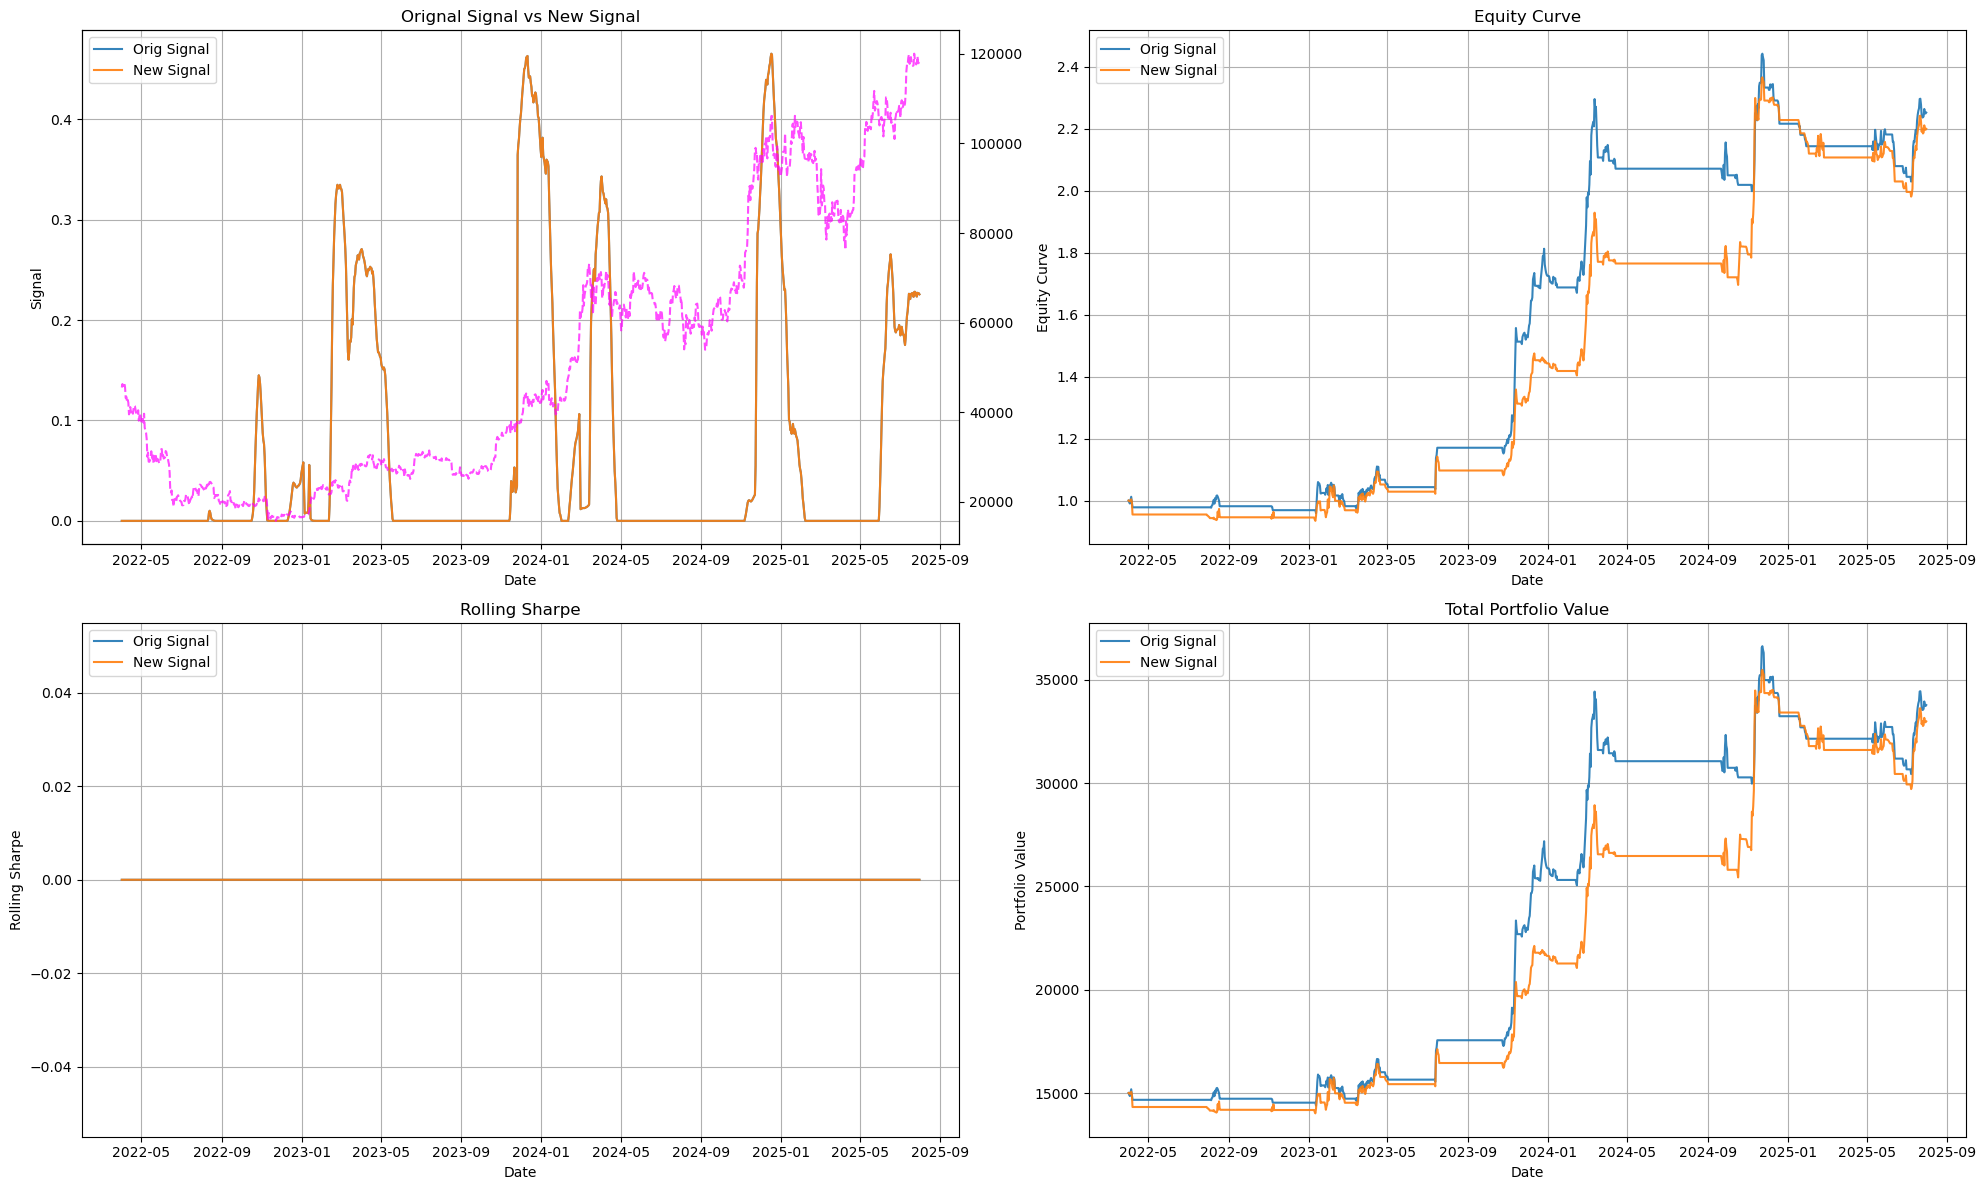

In [75]:
plot_signal_performance(df_1=df_final_prod_config, df_2=df_final_prod_config_expanded, ticker='BTC-USD')

In [65]:
df_final_prod_config_expanded.head()

BTC-USD_20_avg_true_range_price  BTC-USD_actual_position_notional  \
date                                                                            
2022-04-01                      1780.785957                               0.0   
2022-04-02                      1849.890152                               0.0   
2022-04-03                      1823.859661                               0.0   
2022-04-04                      1832.761598                               0.0   
2022-04-05                      1826.790970                               0.0   

            BTC-USD_actual_position_size  BTC-USD_annualized_volatility_30  \
date                                                                         
2022-04-01                           0.0                          0.630578   
2022-04-02                           0.0                          0.630971   
2022-04-03                           0.0                          0.619842   
2022-04-04                           0.0                          0.547727   
2022-04-05                           0.0                          0.547786   

            BTC-USD_close  BTC-USD_cooldown_counter BTC-USD_event  \
date                                                                
2022-04-01       46296.34                       0.0             0   
2022-04-02       45826.27                       0.0   No Position   
2022-04-03       46422.16                       0.0   No Position   
2022-04-04       46596.83                       0.0   No Position   
2022-04-05       45506.50                       0.0   No Position   

            BTC-USD_final_signal  BTC-USD_final_weighted_additive_signal  \
date                                                                       
2022-04-01          2.019917e-07                                0.102882   
2022-04-02          2.288404e-07                                0.128427   
2022-04-03          1.712324e-07                                0.150039   
2022-04-04          1.390267e-07                                0.176089   
2022-04-05          8.963782e-08                                0.202481   

            BTC-USD_highest_high_56  BTC-USD_lowest_low_56  \
date                                                         
2022-04-01                  48240.0                34322.0   
2022-04-02                  48240.0                34322.0   
2022-04-03                  48240.0                34322.0   
2022-04-04                  48240.0                34322.0   
2022-04-05                  48240.0                34322.0   

            BTC-USD_new_position_entry_exit_price  \
date                                                
2022-04-01                                   0.00   
2022-04-02                               46296.36   
2022-04-03                               45826.24   
2022-04-04                               46420.08   
2022-04-05                               46594.39   

            BTC-USD_new_position_notional  BTC-USD_new_position_size  \
date                                                                   
2022-04-01                            0.0                        0.0   
2022-04-02                            0.0                        0.0   
2022-04-03                            0.0                        0.0   
2022-04-04                            0.0                        0.0   
2022-04-05                            0.0                        0.0   

            BTC-USD_open  BTC-USD_open_position_notional  \
date                                                       
2022-04-01      45525.25                             0.0   
2022-04-02      46296.36                             0.0   
2022-04-03      45826.24                             0.0   
2022-04-04      46420.08                             0.0   
2022-04-05      46594.39                             0.0   

            BTC-USD_open_position_size  BTC-USD_short_sale_proceeds  \
date                                                                  
2022-

<Axes: xlabel='date'>

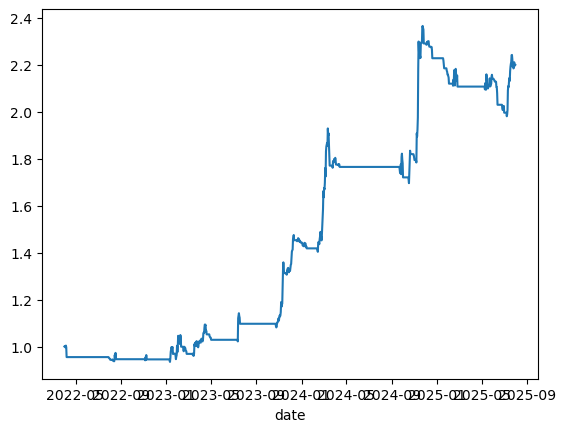

In [73]:
df_final_prod_config_expanded['equity_curve'].plot()

<Axes: xlabel='date'>

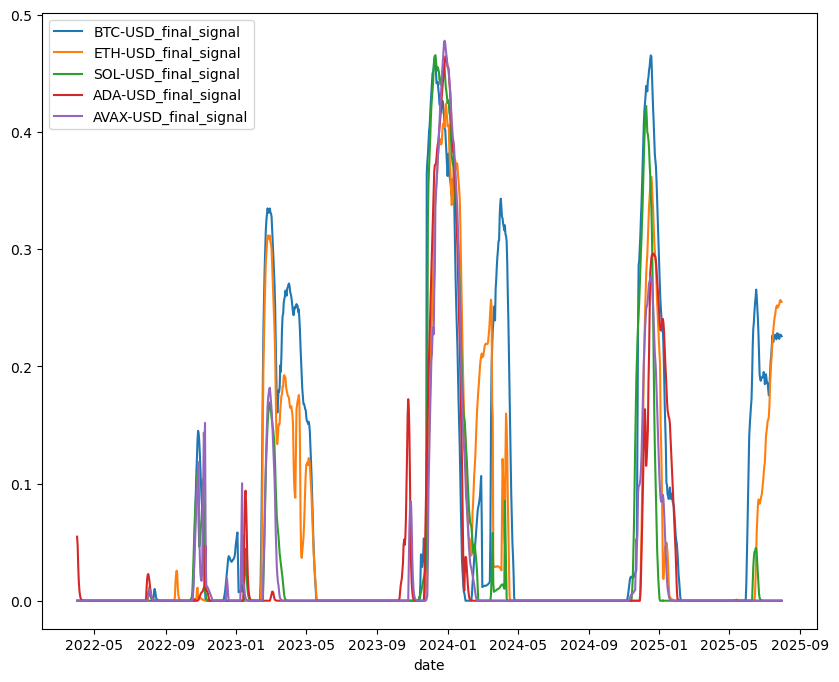

In [103]:
final_signal_cols = [f'{ticker}_final_signal' for ticker in cfg['universe']['tickers']]
df_final_prod_config[final_signal_cols].plot(figsize=(10, 8))

<Axes: xlabel='date'>

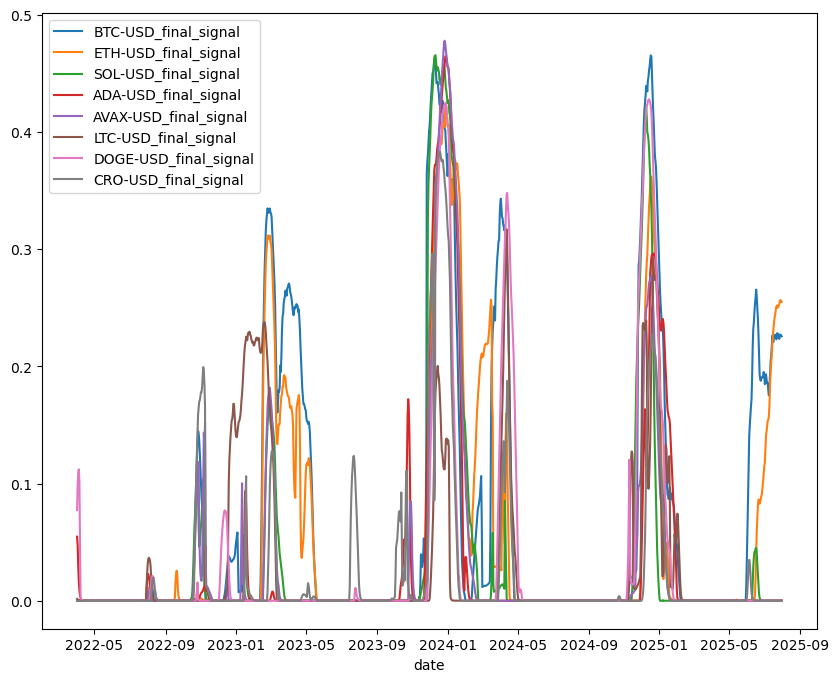

In [105]:
final_signal_cols = [f'{ticker}_final_signal' for ticker in ticker_list]
df_final_prod_config_expanded[final_signal_cols].plot(figsize=(10, 8))

<Axes: xlabel='date'>

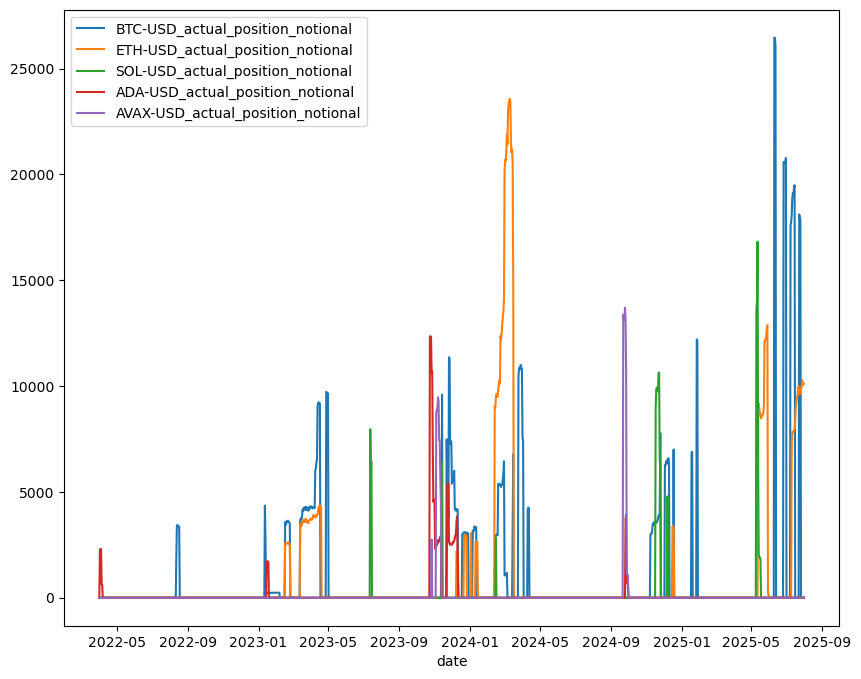

In [111]:
return_cols = [f'{ticker}_actual_position_notional' for ticker in cfg['universe']['tickers']]
df_final_prod_config_expanded[return_cols].plot(figsize=(10, 8))

<Axes: xlabel='date'>

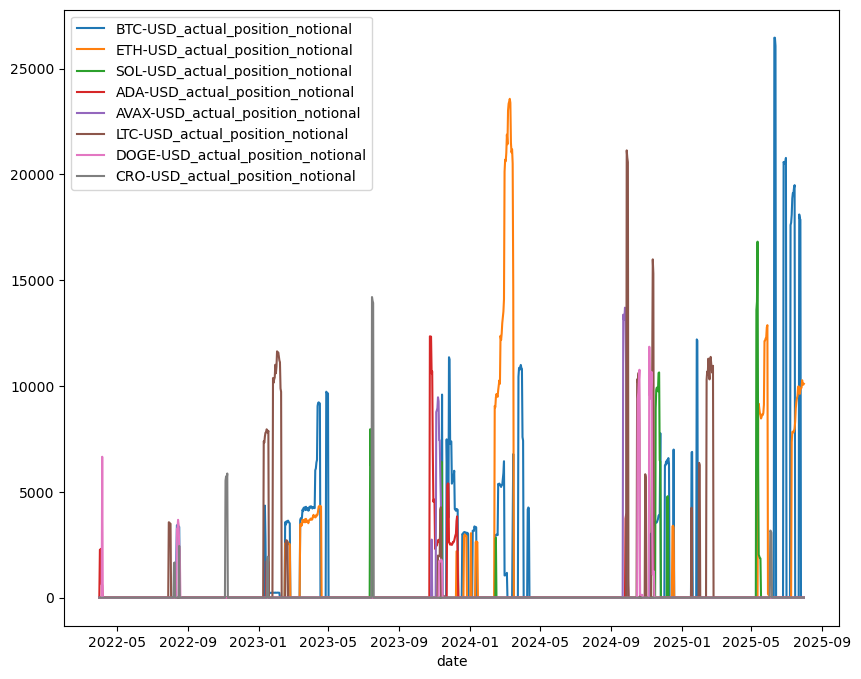

In [109]:
return_cols = [f'{ticker}_actual_position_notional' for ticker in ticker_list]
df_final_prod_config_expanded[return_cols].plot(figsize=(10, 8))

<Axes: xlabel='date'>

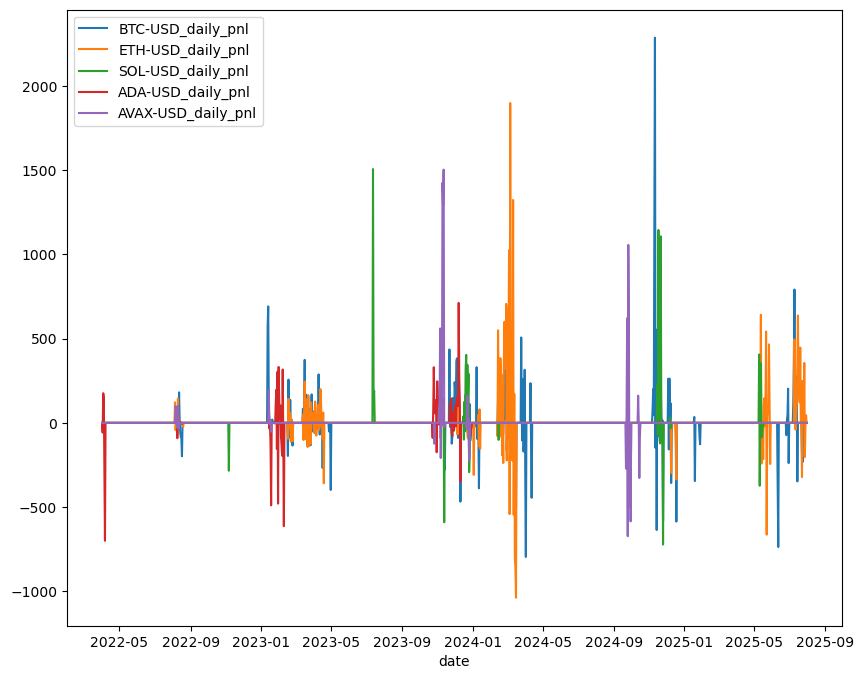

In [117]:
return_cols = [f'{ticker}_daily_pnl' for ticker in cfg['universe']['tickers']]
df_final_prod_config[return_cols].plot(figsize=(10, 8))

<Axes: xlabel='date'>

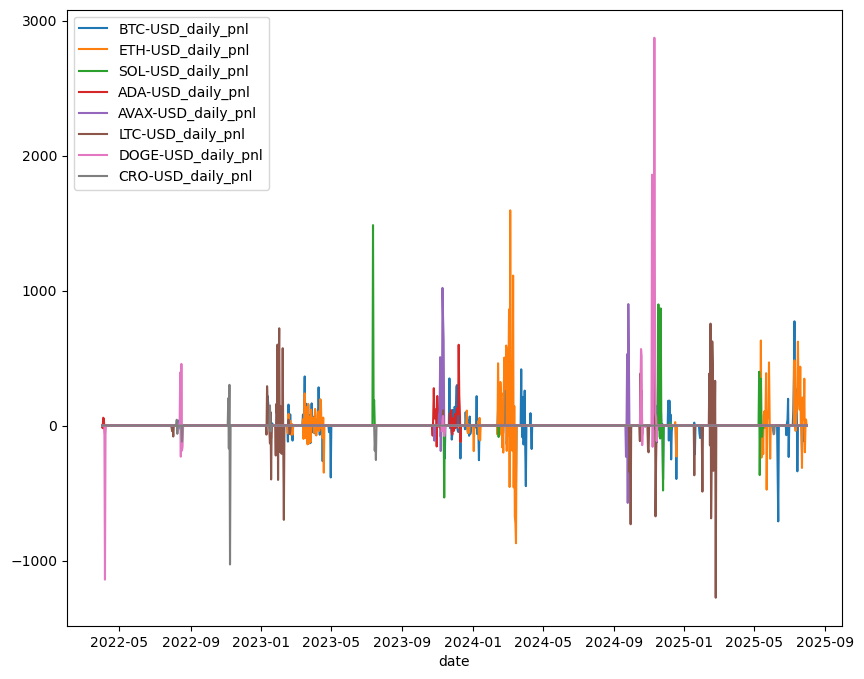

In [115]:
return_cols = [f'{ticker}_daily_pnl' for ticker in ticker_list]
df_final_prod_config_expanded[return_cols].plot(figsize=(10, 8))

<Axes: xlabel='date'>

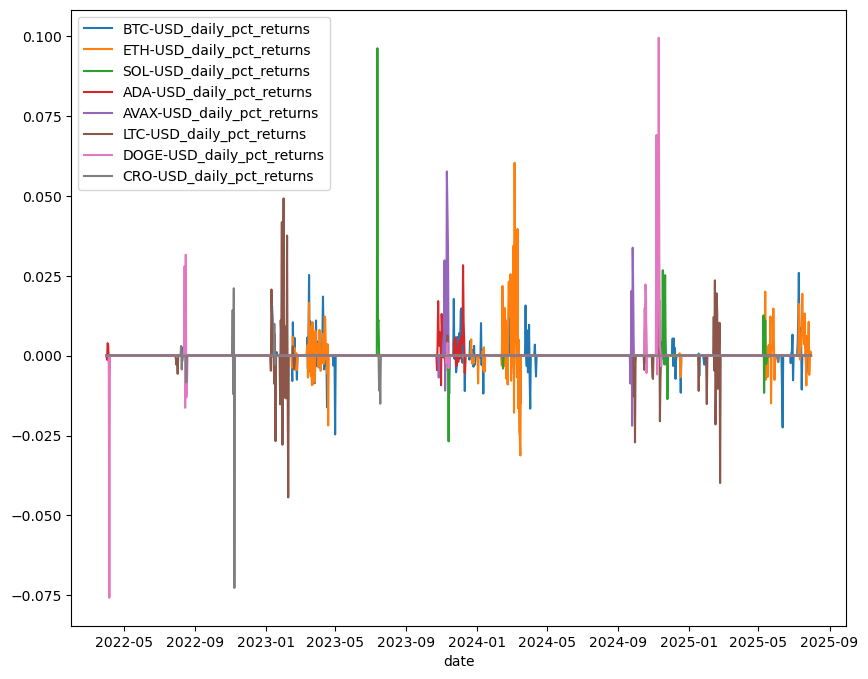

In [113]:
return_cols = [f'{ticker}_daily_pct_returns' for ticker in ticker_list]
df_final_prod_config_expanded[return_cols].plot(figsize=(10, 8))

## Get a list of all tradeable coins from Coinbase on any given day

In [122]:
client = cn.get_coinbase_rest_api_client(portfolio_name='Default')

In [132]:
len(client.get_products()['products'])

812

In [212]:
def product_to_dict(p):
    # Pydantic v2
    fn = getattr(p, "model_dump", None)
    if callable(fn):
        return fn(exclude_none=True)  # or fn() if you want Nones

    # Pydantic v1
    fn = getattr(p, "dict", None)
    if callable(fn):
        return fn()

    # JSON fallbacks (v2 and v1 respectively)
    fn = getattr(p, "model_dump_json", None)
    if callable(fn):
        return json.loads(p.model_dump_json())
    fn = getattr(p, "json", None)
    if callable(fn):
        return json.loads(p.json())

    # Last-resort: plain object
    if hasattr(p, "__dict__"):
        return {k: v for k, v in vars(p).items() if not k.startswith("_")}

    return {"raw": str(p)}

In [294]:
PRODUCTS_DIR = Path("/Users/adheerchauhan/Documents/git/trend_following/data_folder/universe/products")

In [296]:
PRODUCTS_DIR

PosixPath('/Users/adheerchauhan/Documents/git/trend_following/data_folder/universe/products')

In [292]:
pwd

'/Users/adheerchauhan/Documents/git/trend_following/research/notebooks'

In [314]:
CANON_QUOTE = "USD"
PRODUCTS_DIR = Path("/Users/adheerchauhan/Documents/git/trend_following/data_folder/universe/products")
PRODUCTS_DIR.mkdir(parents=True, exist_ok=True)

def coinbase_product_snapshot(client, asof=None, save=True):

    asof = asof or datetime.now(timezone.utc).date().isoformat()
    prod = client.get_products()['products']
    rows = [product_to_dict(p) for p in prod]
    df = pd.json_normalize(rows)

    # optional: keep only columns you care about
    reqd_cols = [
        "product_id","base_currency_id","quote_currency_id","product_type","status",
        "trading_disabled","is_disabled","cancel_only","limit_only","post_only","auction_mode","view_only",
        "base_increment","quote_increment","price_increment","base_min_size","quote_min_size",
        "alias","alias_to","display_name","product_venue","new_at","price","approximate_quote_24h_volume"
    ]
    df = df[reqd_cols]

    # optional: coerce numerics
    num_cols = ["base_increment","quote_increment","price_increment","base_min_size","quote_min_size",
                "price","approximate_quote_24h_volume"]
    for col in num_cols:
        if col in df_products.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    # Filter to USD spot & tradable
    filt = (
        (df["product_type"] == "SPOT") &
        (df["quote_currency_id"] == CANON_QUOTE) &
        (df["status"] == "online") &
        (~df["trading_disabled"]) &
        (~df["is_disabled"]) &
        (~df["view_only"]) &
        (~df["cancel_only"]) &
        (~df["auction_mode"])
    )
    df = df[filt]

    df["asof_date"] = pd.to_datetime(asof).date()

    if save:
        out = PRODUCTS_DIR / f"{asof}_prod.parquet"
        df.to_parquet(out, index=False)

    return df

In [316]:
client = cn.get_coinbase_rest_api_client(portfolio_name='Default')

In [330]:
datetime.now(timezone.utc).date().isoformat()

'2025-10-24'

In [332]:
df_products_t_1 = coinbase_product_snapshot(client, asof=pd.Timestamp('2025-10-23').date(), save=True)

In [336]:
df_products_t_1

product_id base_currency_id quote_currency_id product_type  status  \
0           BTC-USD              BTC               USD         SPOT  online   
2           ETH-USD              ETH               USD         SPOT  online   
4           SOL-USD              SOL               USD         SPOT  online   
6           XRP-USD              XRP               USD         SPOT  online   
8           SUI-USD              SUI               USD         SPOT  online   
10         USDT-USD             USDT               USD         SPOT  online   
12         AVNT-USD             AVNT               USD         SPOT  online   
15         DOGE-USD             DOGE               USD         SPOT  online   
18          ZEC-USD              ZEC               USD         SPOT  online   
21         LINK-USD             LINK               USD         SPOT  online   
23          ADA-USD              ADA               USD         SPOT  online   
25         WLFI-USD             WLFI               USD         SPOT  online   
27         HBAR-USD             HBAR               USD         SPOT  online   
29          LTC-USD              LTC               USD         SPOT  online   
31         PUMP-USD             PUMP               USD         SPOT  online   
33      USELESS-USD          USELESS               USD         SPOT  online   
35          TAO-USD              TAO               USD         SPOT  online   
37        PENGU-USD            PENGU               USD         SPOT  online   
39      CLANKER-USD          CLANKER               USD         SPOT  online   
41     FARTCOIN-USD         FARTCOIN               USD         SPOT  online   
43         AVAX-USD             AVAX               USD         SPOT  online   
46          XLM-USD              XLM               USD         SPOT  online   
48         BONK-USD             BONK               USD         SPOT  online   
50         ZORA-USD             ZORA               USD         SPOT  online   
52         PEPE-USD             PEPE               USD         SPOT  online   
54          FET-USD              FET               USD         SPOT  online   
57          ENA-USD              ENA               USD         SPOT  online   
59         ONDO-USD             ONDO               USD         SPOT  online   
61           YB-USD               YB               USD         SPOT  online   
63         AAVE-USD             AAVE               USD         SPOT  online   
65       RECALL-USD           RECALL               USD         SPOT  online   
67          SEI-USD              SEI               USD         SPOT  online   
69         AERO-USD             AERO               USD         SPOT  online   
72          DOT-USD              DOT               USD         SPOT  online   
75          APR-USD              APR               USD         SPOT  online   
77          KTA-USD              KTA               USD         SPOT  online   
79          CRV-USD              CRV               USD         SPOT  online   
82        JASMY-USD            JASMY               USD         SPOT  online   
86          BCH-USD              BCH               USD         SPOT  online   
88        TOSHI-USD            TOSHI               USD         SPOT  online   
90        PROVE-USD            PROVE               USD         SPOT  online   
92         PAXG-USD             PAXG               USD         SPOT  online   
94          BNB-USD              BNB               USD         SPOT  online   
96         NEAR-USD             NEAR               USD         SPOT  online   
98          MET-USD              MET               USD         SPOT  online   
101         UNI-USD              UNI               USD         SPOT  online   
104         ARB-USD              ARB               USD         SPOT  online   
106      PENDLE-USD           PENDLE               USD         SPOT  online   
108         ICP-USD              ICP               USD         SPOT  online   
113         SNX-USD              SNX               USD     

In [318]:
df_products = coinbase_product_snapshot(client, asof=None, save=True)

In [322]:
df_products

product_id base_currency_id quote_currency_id product_type  status  \
0           BTC-USD              BTC               USD         SPOT  online   
2           ETH-USD              ETH               USD         SPOT  online   
4           SOL-USD              SOL               USD         SPOT  online   
6           XRP-USD              XRP               USD         SPOT  online   
8           SUI-USD              SUI               USD         SPOT  online   
10         USDT-USD             USDT               USD         SPOT  online   
12         AVNT-USD             AVNT               USD         SPOT  online   
15         DOGE-USD             DOGE               USD         SPOT  online   
18          ZEC-USD              ZEC               USD         SPOT  online   
21         LINK-USD             LINK               USD         SPOT  online   
23          ADA-USD              ADA               USD         SPOT  online   
25         WLFI-USD             WLFI               USD         SPOT  online   
27         HBAR-USD             HBAR               USD         SPOT  online   
29          LTC-USD              LTC               USD         SPOT  online   
31         PUMP-USD             PUMP               USD         SPOT  online   
33      USELESS-USD          USELESS               USD         SPOT  online   
35          TAO-USD              TAO               USD         SPOT  online   
37        PENGU-USD            PENGU               USD         SPOT  online   
39      CLANKER-USD          CLANKER               USD         SPOT  online   
41     FARTCOIN-USD         FARTCOIN               USD         SPOT  online   
43         AVAX-USD             AVAX               USD         SPOT  online   
46          XLM-USD              XLM               USD         SPOT  online   
48         BONK-USD             BONK               USD         SPOT  online   
50         ZORA-USD             ZORA               USD         SPOT  online   
52         PEPE-USD             PEPE               USD         SPOT  online   
54          FET-USD              FET               USD         SPOT  online   
57          ENA-USD              ENA               USD         SPOT  online   
59         ONDO-USD             ONDO               USD         SPOT  online   
61           YB-USD               YB               USD         SPOT  online   
63       RECALL-USD           RECALL               USD         SPOT  online   
65         AAVE-USD             AAVE               USD         SPOT  online   
67          SEI-USD              SEI               USD         SPOT  online   
69         AERO-USD             AERO               USD         SPOT  online   
72          DOT-USD              DOT               USD         SPOT  online   
75          APR-USD              APR               USD         SPOT  online   
77          KTA-USD              KTA               USD         SPOT  online   
79          CRV-USD              CRV               USD         SPOT  online   
82        JASMY-USD            JASMY               USD         SPOT  online   
86          BCH-USD              BCH               USD         SPOT  online   
88        TOSHI-USD            TOSHI               USD         SPOT  online   
90        PROVE-USD            PROVE               USD         SPOT  online   
92         PAXG-USD             PAXG               USD         SPOT  online   
94          BNB-USD              BNB               USD         SPOT  online   
96         NEAR-USD             NEAR               USD         SPOT  online   
98          MET-USD              MET               USD         SPOT  online   
101         UNI-USD              UNI               USD         SPOT  online   
104         ARB-USD              ARB               USD         SPOT  online   
106      PENDLE-USD           PENDLE               USD         SPOT  online   
108         ICP-USD              ICP               USD         SPOT  online   
113         SNX-USD              SNX               USD     

In [380]:
def products_diff(prev_path, curr_path):
    
    prev = pd.read_parquet(prev_path)
    curr = pd.read_parquet(curr_path)
    prev_set = set(prev["ticker"])
    curr_set = set(curr["ticker"])
    adds = sorted(list(curr_set - prev_set))
    drops = sorted(list(prev_set - curr_set))
    
    return {"adds": adds, "drops": drops}

In [ ]:
ticker = 'XRP-USD'
start_date = 
df_ohlc = cn.save_historical_crypto_prices_from_coinbase()

In [ ]:
# liquidity_metrics.py
def compute_adv_and_spread(df_ohlcv, window=90):
    """
    df_ohlcv: Multi-asset daily OHLCV with columns:
       ['date','ticker','open','high','low','close','volume']  # volume in base units
    Returns per-day per-ticker ADV (USD) and median spread proxy (bps).
    """
    df = df_ohlcv.copy()
    df["notional_usd"] = df["close"] * df["volume"]
    adv = (df
           .groupby("ticker")
           .apply(lambda g: g.set_index("date")["notional_usd"]
                  .rolling(window, min_periods=max(30, window//3)).median())
           .rename("adv_usd_median_90")
           .reset_index())

    # If you don’t have L1 quotes, use a conservative spread proxy:
    df["spread_bps_proxy"] = (df["high"] - df["low"]) / ((df["high"] + df["low"])/2) * 1e4
    spr = (df
           .groupby("ticker")
           .apply(lambda g: g.set_index("date")["spread_bps_proxy"]
                  .rolling(window, min_periods=max(30, window//3)).median())
           .rename("spread_bps_median_90")
           .reset_index())
    out = adv.merge(spr, on=["ticker","date"], how="outer")
    # history_days (since first valid bar)
    first_date = (df.dropna(subset=["close"])
                  .groupby("ticker")["date"].min()
                  .rename("first_date")
                  .reset_index())
    out = out.merge(first_date, on="ticker", how="left")
    out["history_days"] = (pd.to_datetime(out["date"]) - pd.to_datetime(out["first_date"])).dt.days
    return out


In [238]:
prod = client.get_products()['products']
rows = [product_to_dict(p) for p in prod]
df_products = pd.json_normalize(rows)    

In [256]:
# optional: keep only columns you care about
reqd_cols = [
    "product_id","base_currency_id","quote_currency_id","product_type","status",
    "trading_disabled","is_disabled","cancel_only","limit_only","post_only","auction_mode","view_only",
    "base_increment","quote_increment","price_increment","base_min_size","quote_min_size",
    "alias","alias_to","display_name","product_venue","new_at","price","approximate_quote_24h_volume"
]
df_products = df_products[reqd_cols]

# optional: coerce numerics
for col in ["base_increment","quote_increment","price_increment","base_min_size","quote_min_size",
            "price","approximate_quote_24h_volume"]:
    if col in df_products.columns:
        df_products[col] = pd.to_numeric(df_products[col], errors="coerce")

In [276]:
CANON_QUOTE = "USD"
# Filter to USD spot & tradable
filt = (
    (df_products["product_type"] == "SPOT") &
    (df_products["quote_currency_id"] == CANON_QUOTE) &
    (df_products["status"] == "online") &
    (~df_products["trading_disabled"]) &
    (~df_products["is_disabled"]) &
    (~df_products["view_only"]) &
    (~df_products["cancel_only"]) &
    (~df_products["auction_mode"])
)
df_products = df_products[filt]

In [284]:
df_products.groupby(['base_currency_id']).size()

base_currency_id
00            1
1INCH         1
2Z            1
A8            1
AAVE          1
ABT           1
ACH           1
ACS           1
ACX           1
ADA           1
AERGO         1
AERO          1
AGLD          1
AIOZ          1
AKT           1
ALCX          1
ALEO          1
ALEPH         1
ALGO          1
ALICE         1
ALT           1
AMP           1
ANKR          1
APE           1
API3          1
APT           1
ARB           1
ARKM          1
ARPA          1
ASM           1
AST           1
ATH           1
ATOM          1
AUCTION       1
AUDIO         1
AURORA        1
AVAX          1
AVNT          1
AVT           1
AWE           1
AXL           1
AXS           1
B3            1
BADGER        1
BAL           1
BAND          1
BARD          1
BAT           1
BCH           1
BERA          1
BICO          1
BIGTIME       1
BIO           1
BLAST         1
BLUR          1
BLZ           1
BNB           1
BNKR          1
BNT           1
BOBA          1
BONK          1
BTC    

In [286]:
df_products.alias_to

0             [BTC-USDC]
2             [ETH-USDC]
4             [SOL-USDC]
6             [XRP-USDC]
9             [SUI-USDC]
11           [DOGE-USDC]
14            [ZEC-USDC]
16                    []
19           [LINK-USDC]
21           [AVNT-USDC]
23            [ADA-USDC]
25            [LTC-USDC]
27           [HBAR-USDC]
30            [TAO-USDC]
32        [USELESS-USDC]
34           [AAVE-USDC]
37          [PENGU-USDC]
39         [RECALL-USDC]
41            [XLM-USDC]
43           [PEPE-USDC]
45           [AVAX-USDC]
47           [ZORA-USDC]
49           [BONK-USDC]
51            [ENA-USDC]
53            [BCH-USDC]
55       [FARTCOIN-USDC]
57            [FET-USDC]
59           [PUMP-USDC]
62            [DOT-USDC]
64           [ONDO-USDC]
67            [KTA-USDC]
69            [SEI-USDC]
71           [AERO-USDC]
73           [PAXG-USDC]
75             [YB-USDC]
77            [CRV-USDC]
79            [WIF-USDC]
81          [JASMY-USDC]
85          [TOSHI-USDC]
87           [WLFI-USDC]


In [272]:
df_products.shape

(812, 24)

In [270]:
df_products[filt].shape

(334, 24)

In [262]:
type(df_products.trading_disabled.iloc[0])

numpy.bool_

In [258]:
df_products.head()

product_id base_currency_id quote_currency_id product_type  status  \
0    BTC-USD              BTC               USD         SPOT  online   
1   BTC-USDC              BTC              USDC         SPOT  online   
2    ETH-USD              ETH               USD         SPOT  online   
3   ETH-USDC              ETH              USDC         SPOT  online   
4    SOL-USD              SOL               USD         SPOT  online   

   trading_disabled  is_disabled  cancel_only  limit_only  post_only  \
0             False        False        False       False      False   
1             False        False        False       False      False   
2             False        False        False       False      False   
3             False        False        False       False      False   
4             False        False        False       False      False   

   auction_mode  view_only  base_increment  quote_increment  price_increment  \
0         False      False    1.000000e-08             0.01             0.01   
1         False      False    1.000000e-08             0.01             0.01   
2         False      False    1.000000e-08             0.01             0.01   
3         False      False    1.000000e-08             0.01             0.01   
4         False      False    1.000000e-08             0.01             0.01   

   base_min_size  quote_min_size    alias    alias_to display_name  \
0   1.000000e-08             1.0           [BTC-USDC]      BTC-USD   
1   1.000000e-08             1.0  BTC-USD          []     BTC-USDC   
2   1.000000e-08             1.0           [ETH-USDC]      ETH-USD   
3   1.000000e-08             1.0  ETH-USD          []     ETH-USDC   
4   1.000000e-08             1.0           [SOL-USDC]      SOL-USD   

  product_venue                new_at      price  approximate_quote_24h_volume  
0           CBE  2023-01-01T00:00:00Z  109414.09                  9.425294e+08  
1           CBE  2023-01-01T00:00:00Z  109414.09                  9.425294e+08  
2           CBE  2023-01-01T00:00:00Z    3876.91                  5.170564e+08  
3           CBE  2023-01-01T00:00:00Z    3876.91                  5.170564e+08  
4           CBE  2023-01-01T00:00:00Z     188.87                  2.873863e+08

In [242]:
df_products.head()

product_id      price price_percentage_change_24h        volume_24h  \
0    BTC-USD  109414.09            1.34850252787489      8614.3326913   
1   BTC-USDC  109414.09            1.34850252787489      8614.3326913   
2    ETH-USD    3876.91            1.32639513245656   133368.16158114   
3   ETH-USDC    3876.91            1.32639513245656   133368.16158114   
4    SOL-USD     188.87            2.05879174321842  1521608.96185749   

  volume_percentage_change_24h base_increment quote_increment quote_min_size  \
0           -28.72277278861618     0.00000001            0.01              1   
1           -28.72277278861618     0.00000001            0.01              1   
2           -21.79394723586499     0.00000001            0.01              1   
3           -21.79394723586499     0.00000001            0.01              1   
4              1.2441787159876     0.00000001            0.01              1   

  quote_max_size base_min_size base_max_size base_name quote_name  watched  \
0      150000000    0.00000001          3400   Bitcoin  US Dollar     True   
1      150000000    0.00000001          3400   Bitcoin       USDC    False   
2      150000000    0.00000001         42000  Ethereum  US Dollar     True   
3      150000000    0.00000001         42000  Ethereum       USDC    False   
4       25000000    0.00000001       1274000    Solana  US Dollar     True   

   is_disabled    new  status  cancel_only  limit_only  post_only  \
0        False  False  online        False       False      False   
1        False  False  online        False       False      False   
2        False  False  online        False       False      False   
3        False  False  online        False       False      False   
4        False  False  online        False       False      False   

   trading_disabled  auction_mode product_type quote_currency_id  \
0             False         False         SPOT               USD   
1             False         False         SPOT              USDC   
2             False         False         SPOT               USD   
3             False         False         SPOT              USDC   
4             False         False         SPOT               USD   

  base_currency_id fcm_trading_session_details mid_market_price    alias  \
0              BTC                        None                             
1              BTC                        None                   BTC-USD   
2              ETH                        None                             
3              ETH                        None                   ETH-USD   
4              SOL                        None                             

     alias_to base_display_symbol quote_display_symbol  view_only  \
0  [BTC-USDC]                 BTC                  USD      False   
1          []                 BTC                  USD      False   
2  [ETH-USDC]                 ETH                  USD      False   
3          []                 ETH                  USD      False   
4  [SOL-USDC]                 SOL                  USD      False   

  price_increment display_name product_venue approximate_quote_24h_volume  \
0            0.01      BTC-USD           CBE                 942529372.38   
1            0.01     BTC-USDC           CBE                 942529372.38   
2            0.01      ETH-USD           CBE                 517056359.32   
3            0.01     ETH-USDC           CBE                 517056359.32   
4            0.01      SOL-USD           CBE                 287386284.63   

                 new_at market_cap base_cbrn quote_cbrn product_cbrn  \
0  2023-01-01T00:00:00Z                                                
1  2023-01-01T00:00:00Z                                                
2  2023-01-01T00:00:00Z                                                
3  2023-01-01T00:00:00Z                                                
4  2023-01-01T00:00:00Z                                                

  icon_color icon_url

In [ ]:
# universe.py
from pathlib import Path
import pandas as pd
import json
from datetime import datetime, timezone

PRODUCTS_DIR = Path("data_folder/universe/products")
PRODUCTS_DIR.mkdir(parents=True, exist_ok=True)

CANON_QUOTE = "USD"

def _to_bool(x):
    # Coinbase fields come as bools or strings; normalize
    if isinstance(x, bool): return x
    if x is None: return False
    s = str(x).strip().lower()
    return s in ("true", "1", "yes")

def coinbase_products_snapshot(client, asof=None, save=True):
    asof = asof or datetime.now(timezone.utc).date().isoformat()
    raw = client.get_products()['products']
    df = pd.DataFrame(raw)

    # Ensure missing columns exist
    for col in ["alias","alias_to","min_market_funds"]:
        if col not in df.columns: df[col] = None

    # Filter to USD spot & tradable
    filt = (
        (df["product_type"] == "SPOT") &
        (df["quote_currency_id"] == CANON_QUOTE) &
        (df["status"] == "online") &
        (~df["trading_disabled"].apply(_to_bool)) &
        (~df["is_disabled"].apply(_to_bool)) &
        (~df["view_only"].apply(_to_bool)) &
        (~df["cancel_only"].apply(_to_bool)) &
        (~df["auction_mode"].apply(_to_bool))
    )
    df = df.loc[filt].copy()

    # Canonicalize: prefer -USD symbol if aliasing points to it
    # Build a map: if row.alias is a valid USD symbol, use alias as canonical id
    def canon_pid(row):
        alias = (row.get("alias") or "").strip()
        pid = row["product_id"]
        return alias if alias.endswith("-USD") and len(alias) > 0 else pid

    df["canonical_product_id"] = df.apply(canon_pid, axis=1)

    # Deduplicate on canonical product id, prefer the row whose product_id endswith('-USD')
    df["prefer_usd_flag"] = df["product_id"].str.endswith("-USD")
    df = (df.sort_values(["canonical_product_id","prefer_usd_flag"], ascending=[True, False])
            .drop_duplicates(subset=["canonical_product_id"], keep="first"))

    # Keep a lean schema for downstream
    keep_cols = [
        "canonical_product_id","product_id","base_currency_id","quote_currency_id","product_type","status",
        "trading_disabled","is_disabled","cancel_only","limit_only","post_only","auction_mode","view_only",
        "base_increment","quote_increment","price_increment","base_min_size","quote_min_size","min_market_funds",
        "alias","alias_to","display_name","product_venue","new_at"
    ]
    df = df[keep_cols].rename(columns={"canonical_product_id":"ticker"})

    # Coerce numerics where helpful
    for col in ["base_increment","quote_increment","price_increment","base_min_size","quote_min_size","min_market_funds"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    df["asof_date"] = pd.to_datetime(asof).date()

    if save:
        out = PRODUCTS_DIR / f"{asof}.parquet"
        df.to_parquet(out, index=False)
    return df
